## Will a Wide Receiver be good in the NFL?

I have many thoughts about how wide receivers can be projected coming out of college into the NFL.

As a Patriots fan, I have seen many receivers drafted in the first or second round and have them get cut only a few years later. Although I don't expect any pity given the Super Bowls I remember so fondly, I also remember our last great drafted receiver being a quarterback from Kent State in the 7th round named Julian Edelman, and our more recent pretty good receiver being a Quarterback from NC State named Jakobi Meyers. Why did Bill have an easier time finding QBs converting to WRs than people that played WR their whole lives and are 99th percentile athletes? Blows my mind. 

We look back at the Nkeal Harry draft and wince at the fact that nearly every other first round pick was a hit AND some of the best receivers in the league were taken after him. DK Metcalf, AJ Brown, Deebo Samuel, Terry McLaurin... c'mon man. 

Given the fact that I feel it can't be THAT hard, I will be pooling together public data about these draft prospects and finding if data and relatively simple modeling strategy can predict whether a guy is going to be good before he's going to be good.

As a data scientist and not a scout that's watching an athlete from the stands at the Senior Bowl, during their college season, or following their career closely in the NFL, I need to find some proxies to determine what gives a WR a hand up in the draft process and what determines success in the NFL.

My first step is to determine a proxy for success in the NFL. Although not a perfect measurement, my metric will be APY as a % of Cap at Signing from [Over The Cap](https://overthecap.com/). Although we still need to account for the inflation of the WR market, this metric helps control for the changing salary cap while also representing how much a team is willing to invest in a player. We will specifically be looking at every players second contract to represent how well the prospect performed on their rookie deal to earn that second contract. Obviously players are overpaid or take pay cuts to play on a good team, we can figure that out later.

My hypothesis is that elite receivers are usually 6'0 to 6'2 and around 195 to 210. My ideal receiver in my mind is someone that is 6'1 200 lbs with long arms (Yes, I'm basically just describing Justin Jefferson). Smaller will likely be easily pushed around on routes and can't play on all downs to block for running plays. Larger will likely not move well enough to get separation or yards after catch against NFL defenders and will become a contested catch merchant. 

<img src="https://patriotswire.usatoday.com/wp-content/uploads/sites/71/2024/08/USATSI_23983546.jpg?w=1000&h=600&crop=1" alt="Jalynn Polk" width="800">


# Table of Contents

## [Sneak Peak at Results](#Lets-skip-to-the-good-part)

## [Section 1. Import and Clean the data](#Section-1.-Import-and-Clean-the-data)
- [Combine Data](#a.-Scrape-Combine-Data)

- [Prospect Grades](#b.-Scrape-WR-Prospect-Grades)
- [Second Contract Data](#c.-Scrape-Second-Contract-Data)
- [College Receiving Stats](#d.-Scrape-Receiving-Stats)
- [Join the data and make model variables](#e.-Join-the-data-and-make-model-variables)
        
## [Section 2. Multiple Linear Regression](#Section-2.-Build-The-Model)
- [Build the Regression Model](##Section-2.-Build-The-Model)
- [Predict APY as % of Cap for the Test Set](#Predict-APY-%-for-10-Receivers-that-got-large-contracts)
        

## [Section 3. Predict The Unseen Young Receivers](#Section-3.-Predict-Contracts-for-2021-through-2024-Draft-Classes¶)
- [Final Results!](#The-Top-5-Predicted-Receivers-from-2021-through-2024:)




# Lets skip to the good part

If you scroll to the bottom of the notebook you will see the top rankings for wide receivers based on their college data. Here are the top results...

# The Top 5 Predicted Receivers from the 2021 through 2024 Draft Classes:

### 1. Jamarr Chase - 6.4%
<img src="https://statico.profootballnetwork.com/wp-content/uploads/2024/11/07193200/jamarr-chase-net-worth-lifestyle-1920x1280.jpg" alt="Jamarr Chase" width="300">



### 2. Rome Odunze - 6.2%
<img src="https://static.clubs.nfl.com/image/upload/t_person_squared_mobile/f_auto/v1725550057/bears/t3lmtlfbcktn3vlxd4bz.jpg" alt="Rome Odunze" width="300">


### 3. Jaxon Smith-Njigba - 5.9%
<img src="https://images.seattletimes.com/wp-content/uploads/2023/09/09062023_1_141406.jpg?d=2040x1632" alt="JSN" width="300">

### 4. Malik Nabers - 5.7%
<img src="https://images2.minutemediacdn.com/image/upload/c_crop,w_1599,h_899,x_0,y_0/c_fill,w_912,ar_16:9,f_auto,q_auto,g_auto/images/voltaxMediaLibrary/mmsport/si/01j8s0dny0qd3rwn3sea.jpg" alt="Nabers" width="300">

### 5. Jameson Williams - 5.5%
<img src="https://static.clubs.nfl.com/image/upload/t_editorial_landscape_12_desktop/lions/llgjkaa0a7rd15qupozm" alt="Jamo" width="300">

In [1]:
#Import Tools
import pandas as pd
import numpy as np
import requests
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import string
import re

In [2]:
# set the years
college_years_list = ['2010','2011','2012','2013','2014','2015','2016','2017','2018', '2019']
combine_years_list = ['2013','2014','2015','2016','2017','2018','2019', '2020']

## Section 1. Import and Clean the data

## a. Scrape Combine Data

In [3]:
def scrape_combine(years_list):
    class_list = []
    for year in years_list:
        url = f'https://www.pro-football-reference.com/draft/{year}-combine.htm#combine'
        html = requests.get(url).content
        df_list = pd.read_html(html)
        df = df_list[-1]

        #drop rows with headers
        df = df[df["Player"] != "Player"]

        #Rename Drafted NaN values to Undrafted
        df['Drafted (tm/rnd/yr)'] = df['Drafted (tm/rnd/yr)'].fillna('Undrafted / 8th / 251st pick / 2018')
        
        class_list.append(df)
        
    if len(years_list)>1:   
        df = pd.concat(class_list, axis = 0)
        
        #drop NAs now from draft class
        #draft_class18 = draft_class18.dropna()
        
        df = df.drop(df[['College']], axis = 1)
        
    return df

In [4]:
# Import CSV training data
draft_classes = scrape_combine(combine_years_list)
draft_classes.head()

,Player,Pos,School,Ht,Wt,40yd,Vertical,Bench,Broad Jump,3Cone,Shuttle,Drafted (tm/rnd/yr)
0,Oday Aboushi,OT,Virginia,6-5,308,5.41,23.5,17,100,7.92,4.84,New York Jets / 5th / 141st pick / 2013
1,Johnny Adams,CB,Michigan State,5-10,185,4.48,NaN,16,NaN,NaN,NaN,Undrafted / 8th / 251st pick / 2018
2,Robert Alford,CB,SE Louisiana,5-10,188,4.39,40.0,17,132,6.89,4.23,Atlanta Falcons / 2nd / 60th pick / 2013
3,Keenan Allen,WR,California,6-2,206,4.58,NaN,NaN,NaN,NaN,NaN,San Diego Chargers / 3rd / 76th pick / 2013
4,Ryan Allen,P,Louisiana Tech,6-1,229,4.98,NaN,NaN,NaN,NaN,NaN,Undrafted / 8th / 251st pick / 2018


In [5]:
def clean_combine_stats(df):
    df['Ht'] = df['Ht'].fillna('0-0')
    
    # Split the Height into feet and inches, then convert to numeric, 
    # and calculate BMI
    ft_ = df['Ht'].apply(lambda x: x.split('-')[0])
    in_ = df['Ht'].apply(lambda x: x.split('-')[-1])
    ft_ = pd.to_numeric(ft_)
    in_ = pd.to_numeric(in_)
    wt_ = pd.to_numeric(df['Wt'])
    # wt_ = draft_class18['Wt']
    inches_ = (12*ft_) + in_
    m = inches_ * 0.0254
    m2 = m**2
    kg = wt_ * 0.453592
    df['Ht'] = inches_
    df['BMI'] = kg/m2

    
    # Isolate just their draft pick
    df['Draft Pick']= df['Drafted (tm/rnd/yr)'].apply(lambda x: x.split('/')[2])
    # Extract only the numeric part
    df['Draft Pick'] = df['Draft Pick'].str.extract(r'(\d+)').astype(int)


    # Isolate just their draft round
    df['Draft Round']= df['Drafted (tm/rnd/yr)'].apply(lambda x: x.split('/')[1])
    df['Draft Round'] = df['Draft Round'].str[1]
    
    # Isolate just their draft year
    df['Draft Year']= df['Drafted (tm/rnd/yr)'].apply(lambda x: x.split('/')[3])
    #df['Draft Year'] = df['Draft Year'].str[1]

    # drop drafted column
    df = df.drop(df[['Drafted (tm/rnd/yr)']], axis = 1)
    
    # isolate just wide receivers for now
    df = df[df['Pos']== 'WR']

    # mean impute combine stats
    columns = ['Ht', 'Wt', '40yd', 'Vertical', 'Bench', 'Broad Jump', '3Cone', 'Shuttle','BMI']
    for column in columns:
        df[column] = pd.to_numeric(df[column])
        df[column] = df[column].fillna(df[column].mean())
        df[column] = round(df[column],2)
        
    # Create Player_ID
    df['Player_ID'] = df['Player'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)).replace(' ', '').lower())

    
    return df

In [6]:
combine_stats = clean_combine_stats(draft_classes)
combine_stats.head()

,Player,Pos,School,Ht,Wt,40yd,Vertical,Bench,Broad Jump,3Cone,Shuttle,BMI,Draft Pick,Draft Round,Draft Year,Player_ID
3,Keenan Allen,WR,California,74,206,4.58,35.17,13.94,121.62,6.98,4.25,26.45,76,3,2013,keenanallen
12,Tavon Austin,WR,West Virginia,68,174,4.34,32.00,14.00,120.00,6.98,4.01,26.46,8,1,2013,tavonaustin
15,Stedman Bailey,WR,West Virginia,70,193,4.52,34.50,11.00,117.00,6.81,4.09,27.69,92,3,2013,stedmanbailey
31,Alan Bonner,WR,Jacksonville State,70,193,4.59,33.00,14.00,117.00,6.98,4.15,27.69,195,6,2013,alanbonner
34,Josh Boyce,WR,TCU,71,206,4.38,34.00,22.00,131.00,6.68,4.10,28.73,102,4,2013,joshboyce


## b. Scrape WR Prospect Grades

In [7]:
# I manually copied the draft grades from https://www.nfl.com/draft/tracker/prospects/wr/all-colleges/all-statuses/2024?page=3&sortField=gradeSort&sortIsAscending=false
# They are in the google sheet below but I downloaded locally for ease
# google sheet link: https://docs.google.com/spreadsheets/d/1-v-_LSCyjjCrK9H_XTodxq5SJI76wRWUb948AMG_2lM/edit?gid=50233396#gid=50233396
def get_draft_grades(years_list):
    class_list = []
    for year in years_list:
        df = pd.read_excel('WR Draft Grades.xlsx', sheet_name= year)
        #drop rows with headers
        df = df[df["Player"] != "Player"]
        #isolate columns wanted
        df = df[['Player', 'Grade']]
        df['Year'] = year
        # fill in no grade with 0
        df['Grade'] = df['Grade'].fillna(0)
        # drop rows with null
        df = df.dropna()
        # # Isolate just their name
        df['Player']= df['Player'].apply(lambda x: x.split('\n')[0])
        # Create Player_ID
        df['Player_ID'] = df['Player'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)).replace(' ', '').lower())


        
        class_list.append(df)
        
    if len(years_list)>1:   
        df = pd.concat(class_list, axis = 0)
        
        
    return df

In [8]:
draft_grades = get_draft_grades(combine_years_list)
draft_grades.head()

,Player,Grade,Year,Player_ID
0,Cordarrelle Patterson,6.92356,2013,cordarrellepatterson
1,DeAndre Hopkins,6.83228,2013,deandrehopkins
2,Keenan Allen,6.78338,2013,keenanallen
3,Tavon Austin,6.75404,2013,tavonaustin
4,Quinton Patton,6.70188,2013,quintonpatton


## c. Scrape Second Contract Data

In [9]:
def scrape_second_contracts():
    # Import CSV training data, start with WR
    url = 'https://overthecap.com/contract-history/wide-receiver'
    html = requests.get(url).content
    df_list = pd.read_html(html)
    df = df_list[-1]
    
    # take most important columns
    df = df[['Player','Year Signed','APY as % Of Cap At Signing']]
    
    # Sort the DataFrame by Player and Year Signed
    df = df.sort_values(by=['Player', 'Year Signed'])

    # Create a rank within each group of col1 based on col2
    df['rank'] = df.groupby('Player')['Year Signed'].rank(method='first')

    # Filter to keep only rows with rank == 2 (2nd lowest)
    df = df[df['rank'] == 2]

    # Drop the helper 'rank' column (optional)
    df = df.drop(columns=['rank'])

    # Reset the index
    df = df.reset_index(drop=True)

    # convert APY as $ of Cap At Signing to decimal
    df['APY as % Of Cap At Signing'] = df['APY as % Of Cap At Signing'].replace('%', '', regex=True).astype(float) / 100
    
    # create Player_ID
    df['Player_ID'] = df['Player'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)).replace(' ', '').lower())
    
    return df

In [10]:
second_contracts = scrape_second_contracts()
second_contracts.head()

,Player,Year Signed,APY as % Of Cap At Signing,Player_ID
0,A.J. Brown,2022,0.120,ajbrown
1,A.J. Green,2015,0.105,ajgreen
2,A.J. Jenkins,2012,0.014,ajjenkins
3,A.J. Richardson,2019,0.001,ajrichardson
4,A.T. Perry,2024,0.001,atperry


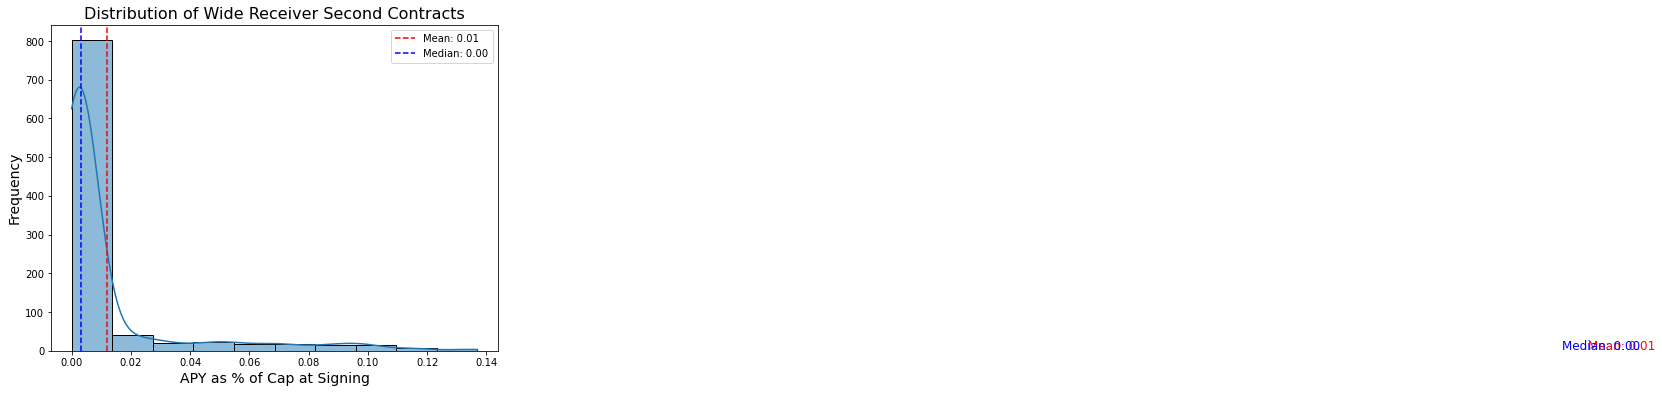

In [11]:
# Calculate the mean and median of the column
mean_value = second_contracts['APY as % Of Cap At Signing'].mean()
median_value = second_contracts['APY as % Of Cap At Signing'].median()

# Set the size of the plot
plt.figure(figsize=(8, 6))

# Create a histogram with Seaborn
sns.histplot(second_contracts['APY as % Of Cap At Signing'], kde=True, bins=10)

# Add a vertical line for the mean value
plt.axvline(mean_value, color='red', linestyle='--', label=f'Mean: {mean_value:.2f}')

# Add a vertical line for the median value
plt.axvline(median_value, color='blue', linestyle='--', label=f'Median: {median_value:.2f}')

# Add the labels for the mean and median
plt.text(mean_value + 0.5, 3, f'Mean: {mean_value:.2f}', color='red', fontsize=12)
plt.text(median_value + 0.5, 3, f'Median: {median_value:.2f}', color='blue', fontsize=12)

# Add title and labels
plt.title('Distribution of Wide Receiver Second Contracts', fontsize=16)
plt.xlabel('APY as % of Cap at Signing', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Display the legend
plt.legend()

# Show the plot
plt.show()

## d. Scrape Receiving Stats

Get Receiving Stats from best season

In [12]:
# Import CSV training data, start with WR
def scrape_receiving_stats(years_list):
    class_list = []
    for year in years_list:
        url = f'https://www.sports-reference.com/cfb/years/{year}-receiving.html'
        html = requests.get(url).content
        df_list = pd.read_html(html)
        df = df_list[-1]
        
        class_list.append(df)
        
    if len(years_list)>1:   
        df = pd.concat(class_list, axis = 0)
        
    # Set the column names to the second row (drop the first row of column headers)
    df.columns = df.columns.get_level_values(1)

    awards = df.Awards

    df = df.iloc[:, :-6]

    df['Awards'] = awards

    # Get the column positions of 'Yds'
    yds_columns = [i for i, col in enumerate(df.columns) if col == 'Yds']

    # Rename the 'Yds' columns
    df.columns.values[yds_columns[0]] = 'rec_yds'
    df.columns.values[yds_columns[1]] = 'rush_yds'

    # Get the column positions of 'Yds'
    td_columns = [i for i, col in enumerate(df.columns) if col == 'TD']

    # Rename the 'Yds' columns
    df.columns.values[td_columns[0]] = 'rec_TD'
    df.columns.values[td_columns[1]] = 'rush_TD'

    # Create the 'award_count' column
    df['award_count'] = df['Awards'].apply(lambda x: 0 if pd.isna(x) else len(x.split(',')))

    # Remove asterisks from the 'Player' column
    df['Player'] = df['Player'].str.replace('*', '', regex=False)
    
    # Create the 'years_played' column
    df['years_played'] = df.groupby('Player')['Player'].transform('count')

    # Sort the dataframe by 'Player' and 'rec_yds' to get the row with the highest 'rec_yds' for each player
    df_sorted = df.sort_values(by=['Player', 'rec_yds'], ascending=[True, False])

    # Drop duplicates based on the 'Player' column, keeping the row with the highest 'rec_yds'
    df = df_sorted.drop_duplicates(subset='Player', keep='first')
    
    
    # fill Y/A with 0
    df['Y/A'] = df['Y/A'].fillna(0)
    
    
    # create player_id
    df['Player_ID'] = df['Player'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)).replace(' ', '').lower())

        
    return df

In [13]:
college_stats = scrape_receiving_stats(college_years_list)
college_stats.sort_values(by = 'Player').head()

,Rk,Player,Team,Conf,G,Rec,rec_yds,Y/R,rec_TD,Y/G,Att,rush_yds,Y/A,rush_TD,Awards,award_count,years_played,Player_ID
1342,1343.0,A J Steward,Kansas,Big 12,12.0,4.0,25.0,6.3,1.0,2.1,0.0,0.0,0.0,0.0,NaN,0,1,ajsteward
1504,1505.0,A'Darius Purifoy,Appalachian State,Sun Belt,5.0,2.0,25.0,12.5,0.0,5.0,0.0,0.0,0.0,0.0,NaN,0,2,adariuspurifoy
876,877.0,A.C. Leonard,Florida,SEC,9.0,8.0,99.0,12.4,0.0,11.0,0.0,0.0,0.0,0.0,NaN,0,1,acleonard
740,741.0,A.D. Miller,Oklahoma,Big 12,12.0,12.0,145.0,12.1,2.0,12.1,0.0,0.0,0.0,0.0,NaN,0,4,admiller
1421,1422.0,A.J. Alexander,Ohio State,Big Ten,13.0,4.0,27.0,6.8,0.0,2.1,0.0,0.0,0.0,0.0,NaN,0,2,ajalexander


## e. Join the data and make model variables

In [14]:
len(combine_stats)

378

In [15]:
combine_stats[combine_stats['Player_ID']== 'ajbrown']

,Player,Pos,School,Ht,Wt,40yd,Vertical,Bench,Broad Jump,3Cone,Shuttle,BMI,Draft Pick,Draft Round,Draft Year,Player_ID
40,A.J. Brown,WR,Mississippi,72,226,4.49,36.5,19.0,120.0,6.98,4.25,30.65,51,2,2019,ajbrown


In [16]:
len(college_stats)

9122

In [17]:
college_stats[college_stats['Player_ID']== 'ajbrown']

,Rk,Player,Team,Conf,G,Rec,rec_yds,Y/R,rec_TD,Y/G,Att,rush_yds,Y/A,rush_TD,Awards,award_count,years_played,Player_ID
6,7.0,A.J. Brown,Ole Miss,SEC,12.0,85.0,1320.0,15.5,6.0,110.0,0.0,0.0,0.0,0.0,NaN,0,3,ajbrown


In [18]:
# Perform the joins
df_merged = combine_stats.merge(college_stats, on=['Player_ID'], how='inner',suffixes=('', '_drop'))

In [19]:
len(df_merged)

344

In [20]:
df_merged[df_merged['Player_ID']== 'ajbrown']

,Player,Pos,School,Ht,Wt,40yd,Vertical,Bench,Broad Jump,3Cone,...,Y/R,rec_TD,Y/G,Att,rush_yds,Y/A,rush_TD,Awards,award_count,years_played
257,A.J. Brown,WR,Mississippi,72,226,4.49,36.5,19.0,120.0,6.98,...,15.5,6.0,110.0,0.0,0.0,0.0,0.0,NaN,0,3


In [21]:
# Perform the joins
df_merged = df_merged.merge(draft_grades, on='Player_ID', how='inner',suffixes=('', '_drop'))

In [22]:
len(df_merged)

362

In [23]:
df_merged[df_merged['Player_ID']== 'ajbrown']
df_merged = df_merged.drop_duplicates()

In [24]:
df_merged = df_merged.merge(second_contracts, on='Player_ID', how='inner', suffixes=('', '_drop'))
df_merged[['Year Signed','APY as % Of Cap At Signing']] = df_merged[['Year Signed','APY as % Of Cap At Signing']].fillna(0)

In [25]:
len(df_merged)

268

In [26]:
df_merged[df_merged['Player_ID']== 'ajbrown']

,Player,Pos,School,Ht,Wt,40yd,Vertical,Bench,Broad Jump,3Cone,...,rush_TD,Awards,award_count,years_played,Player_drop,Grade,Year,Player_drop,Year Signed,APY as % Of Cap At Signing
195,A.J. Brown,WR,Mississippi,72,226,4.49,36.5,19.0,120.0,6.98,...,0.0,NaN,0,3,A.J. Brown,6.7,2019,A.J. Brown,2022,0.12


In [27]:
def create_new_vars(df_merged):
    
    # Create the 'ideal_ht' column: 1 if Ht > 71 and < 75
    df_merged['ideal_ht'] = np.where((df_merged['Ht'] > 71) & (df_merged['Ht'] < 75), 1, 0)

    # Create the 'ideal_wt' column: 1 if Ht > 190 and < 216
    df_merged['ideal_wt'] = np.where((df_merged['Wt'] > 185) & (df_merged['Wt'] < 216), 1, 0)

    # Create the 'ideal_bmi' column: 1 if BMI > 25 and < 31
    df_merged['ideal_bmi'] = np.where((df_merged['BMI'] > 25) & (df_merged['BMI'] < 31), 1, 0)

    # Create the 'ideal_40' column: 1 if 40yd > 4.29 and < 4.6
    df_merged['ideal_40'] = np.where((df_merged['40yd'] > 4.29) & (df_merged['40yd'] < 4.6), 1, 0)

    # Create the 'ideal_shuttle' column: 1 if Shuttle < 4.3
    df_merged['ideal_shuttle'] = np.where((df_merged['Shuttle'] < 4.55), 1, 0)

    # Create 'ideal_all' if all ideal categories are met
    df_merged['ideal_all'] = ((df_merged['ideal_ht'] == 1) & 
                       (df_merged['ideal_bmi'] == 1) & 
                       (df_merged['ideal_40'] == 1) & 
                       (df_merged['ideal_shuttle'] == 1)).astype(int)

    #Create 'elite_production' column
    df_merged['elite_prod'] = np.where((df_merged['rec_yds'] >= 1100 | (df_merged['rec_TD'] >= 10) | (df_merged['Rec'] >= 80)), 1, 0)

    #Create 'td/rec'
    df_merged['td/rec'] =np.where(df_merged['rec_TD'] > 0, df_merged['Rec'] / df_merged['rec_TD'], 0)

    #Create 'rec/g'
    df_merged['rec/g'] =np.where(df_merged['Rec'] > 0, df_merged['Rec'] / df_merged['G'], 0)

    #bmi/shuttle
    df_merged['bmi/shuttle'] = df_merged['BMI'] / df_merged['Shuttle']

    #bmi/bench
    df_merged['bmi/bench'] = df_merged['BMI'] / df_merged['Bench']

    #bmi/40
    df_merged['bmi/40'] = df_merged['BMI'] / df_merged['40yd']

    #bmi/vertical
    df_merged['bmi/vertical'] = df_merged['BMI'] / df_merged['Vertical']

    # Create the 'H_win' column if won the heisman
    # If the number is 1, set 'H_win' to 1
    df_merged['Awards'] = df_merged['Awards'].fillna('None')
    df_merged['H_win'] = df_merged['Awards'].apply(lambda x: 1 if re.search(r'H-(\d+)', x) and int(re.search(r'H-(\d+)', x).group(1)) == 1 else 0)

    # Create dummy variables for the 'School' column
#     df_schools = pd.get_dummies(df_merged['Conf'], prefix='Conf')

    # Combine the original dataframe with the new dummy columns
#     df_merged = pd.concat([df_merged, df_schools], axis=1)
    
    
    return df_merged

In [28]:
df_merged = create_new_vars(df_merged)

## Section 2. Build the Model

In [29]:
interesting_vars = ['Player','Player_ID','Ht','Wt','40yd', 'Vertical',
       'Broad Jump', '3Cone', 'Shuttle', 'BMI', 'Draft Pick', 'Grade',
       'Draft Year', 'G', 'Rec', 'rec_yds', 'Y/R',
       'rec_TD', 'Y/G']


df_merged2 = df_merged[interesting_vars]

In [30]:
# Define the independent variables (X) and the dependent variable (Y)
ind_vars = ['Vertical','Ht','Broad Jump', '3Cone', 'Shuttle', '40yd','BMI',
            'Draft Round', 'Draft Year', 'Grade',
            'rec_yds','Rec','Y/G','years_played', 'rec_TD', 
            'bmi/40', 'bmi/shuttle',
#            'award_count','bmi/vertical',
            
            #dummy vars
            'H_win',
            'elite_prod',
            'ideal_ht','ideal_bmi', 'ideal_40','ideal_shuttle']

X = df_merged[ind_vars] # Independent variables
y = df_merged['APY as % Of Cap At Signing']  # Dependent variable

# Split data into training and test sets (optional, for validation)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Create a linear regression model
model = LinearRegression()

# Fit the model on the training data
model.fit(X_train, y_train)

# Get the model coefficients (weights)
print("Intercept:", model.intercept_)
print("Coefficients:", model.coef_)

# Make predictions
y_pred = model.predict(X_test)

# Print predictions
print("Predictions:", y_pred)

Intercept: -4.325752841027165
Coefficients: [ 3.66681747e-04 -2.43062240e-04 -4.48260495e-04  8.95310734e-03
  5.28226072e-01  3.97997385e-02 -8.97812666e-02 -4.55572262e-03
  9.24690869e-04  1.60310186e-02  3.83816490e-05 -8.17061283e-05
 -2.07326151e-04 -2.29706129e-03 -1.55917168e-03  2.49752853e-02
  3.50217837e-01 -3.33066907e-16  1.11022302e-16 -3.78940390e-04
  6.68781086e-03  2.45000318e-03  2.02430505e-02]
Predictions: [ 0.00396806  0.04153219  0.02049435 -0.00993289 -0.00025489  0.00713876
  0.00415544  0.01383596 -0.02233111 -0.00444266 -0.00574265 -0.00413523
 -0.00350044  0.03054037 -0.01423523  0.02578851  0.04206411 -0.00293299
  0.02685112 -0.00273579  0.00252761  0.04157091  0.00431909  0.05498323
 -0.00517537  0.04440772  0.02205859]


In [31]:
# Calculate accuracy metrics

# R-squared
r2 = r2_score(y_test, y_pred)

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)

# Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Root Mean Squared Error (RMSE)
rmse = mean_squared_error(y_test, y_pred, squared=False)

# Print the metrics
print("R-squared:", r2)
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)

R-squared: 0.29816794565481375
Mean Absolute Error (MAE): 0.020764521638061126
Mean Squared Error (MSE): 0.0009399081207143628
Root Mean Squared Error (RMSE): 0.030657921010961636


In [32]:
# Get feature importance based on coefficients
coefficients = pd.DataFrame(model.coef_, X.columns, columns=['Coefficient'])

# Sort the coefficients by the absolute value to find the most important features
coefficients['Abs_Coefficient'] = coefficients['Coefficient'].abs()
coefficients_sorted = coefficients.sort_values(by='Abs_Coefficient', ascending=False)

# Display the top 5 most important features
top_5_features = coefficients_sorted.head(5)
print("\nTop 5 Most Important Features:")
print(top_5_features)


Top 5 Most Important Features:
             Coefficient  Abs_Coefficient
Shuttle         0.528226         0.528226
bmi/shuttle     0.350218         0.350218
BMI            -0.089781         0.089781
40yd            0.039800         0.039800
bmi/40          0.024975         0.024975


## Predict APY % for 10 Receivers that got large contracts

In [33]:
preds = model.predict(df_merged[X.columns])

In [34]:
df_merged2['Predicted APY as % of Cap'] = preds

df_merged2['APY as % Of Cap At Signing'] = y

In [35]:
# Sort by actual
df_merged2.sort_values(by = 'APY as % Of Cap At Signing', ascending = False).reset_index(drop = True).head(10)

,Player,Player_ID,Ht,Wt,40yd,Vertical,Broad Jump,3Cone,Shuttle,BMI,...,Grade,Draft Year,G,Rec,rec_yds,Y/R,rec_TD,Y/G,Predicted APY as % of Cap,APY as % Of Cap At Signing
0,Justin Jefferson,justinjefferson,73,202,4.43,37.5,126.0,6.98,4.25,26.65,...,6.46,2020,15.0,111.0,1540.0,13.9,18.0,102.7,0.043156,0.137
1,CeeDee Lamb,ceedeelamb,74,198,4.50,34.5,124.0,6.98,4.25,25.42,...,6.81,2020,13.0,62.0,1327.0,21.4,14.0,102.1,0.050909,0.133
2,A.J. Brown,ajbrown,72,226,4.49,36.5,120.0,6.98,4.25,30.65,...,6.7,2019,12.0,85.0,1320.0,15.5,6.0,110.0,0.045791,0.120
3,Brandon Aiyuk,brandonaiyuk,72,205,4.50,40.0,128.0,6.98,4.25,27.80,...,6.38,2020,12.0,65.0,1192.0,18.3,8.0,99.3,0.047183,0.117
4,D.K. Metcalf,dkmetcalf,75,228,4.33,40.5,134.0,7.38,4.50,28.50,...,6.8,2019,12.0,39.0,646.0,16.6,7.0,53.8,0.038772,0.115
5,Terry McLaurin,terrymclaurin,72,208,4.35,37.5,125.0,7.01,4.15,28.21,...,6.1,2019,14.0,35.0,701.0,20.0,11.0,50.1,0.022059,0.111
6,Michael Thomas,michaelthomas,75,212,4.57,35.0,126.0,6.80,4.13,26.50,...,6.3,2016,13.0,71.0,1391.0,19.6,14.0,107.0,0.027023,0.102
7,"Odell Beckham, Jr.",odellbeckhamjr,71,198,4.38,38.5,122.0,6.69,3.94,27.62,...,6.4,2014,13.0,59.0,1152.0,19.5,8.0,88.6,0.056076,0.102
8,Amari Cooper,amaricooper,73,211,4.42,33.0,120.0,6.71,3.98,27.84,...,7.1,2015,14.0,124.0,1727.0,13.9,16.0,123.4,0.060958,0.101
9,Kenny Golladay,kennygolladay,76,218,4.50,35.5,120.0,7.00,4.15,26.54,...,5.9,2017,12.0,87.0,1156.0,13.3,8.0,96.3,0.028745,0.099


In [36]:
# Sort by predicted
df_merged2.sort_values(by = 'Predicted APY as % of Cap', ascending = False).reset_index(drop = True).head(10)

,Player,Player_ID,Ht,Wt,40yd,Vertical,Broad Jump,3Cone,Shuttle,BMI,...,Grade,Draft Year,G,Rec,rec_yds,Y/R,rec_TD,Y/G,Predicted APY as % of Cap,APY as % Of Cap At Signing
0,Jerry Jeudy,jerryjeudy,73,193,4.45,35.00,120.00,6.98,4.53,25.46,...,6.77,2020,15.0,68.0,1315.0,19.3,14.0,87.7,0.072271,0.069
1,Calvin Ridley,calvinridley,72,189,4.43,31.00,110.00,6.88,4.41,25.63,...,6.8,2018,15.0,89.0,1045.0,11.7,7.0,69.7,0.065052,0.090
2,Brandin Cooks,brandincooks,70,189,4.33,36.00,120.00,6.76,3.81,27.12,...,6.3,2014,13.0,128.0,1730.0,13.5,16.0,133.1,0.061144,0.091
3,Amari Cooper,amaricooper,73,211,4.42,33.00,120.00,6.71,3.98,27.84,...,7.1,2015,14.0,124.0,1727.0,13.9,16.0,123.4,0.060958,0.101
4,"Odell Beckham, Jr.",odellbeckhamjr,71,198,4.38,38.50,122.00,6.69,3.94,27.62,...,6.4,2014,13.0,59.0,1152.0,19.5,8.0,88.6,0.056076,0.102
5,Marquise Brown,marquisebrown,69,166,4.51,35.17,121.62,6.98,4.25,24.51,...,6.7,2019,14.0,75.0,1318.0,17.6,10.0,94.1,0.054983,0.027
6,CeeDee Lamb,ceedeelamb,74,198,4.50,34.50,124.00,6.98,4.25,25.42,...,6.81,2020,13.0,62.0,1327.0,21.4,14.0,102.1,0.050909,0.133
7,Kevin White,kevinwhite,75,215,4.35,36.50,123.00,6.92,4.14,26.87,...,6.7,2015,13.0,109.0,1447.0,13.3,10.0,111.3,0.049944,0.008
8,Mike Evans,mikeevans,77,231,4.53,37.00,121.62,7.08,4.26,27.39,...,6.7,2014,13.0,69.0,1394.0,20.2,12.0,107.2,0.049055,0.093
9,Tyler Boyd,tylerboyd,73,197,4.58,34.00,119.00,6.90,4.35,25.99,...,6.4,2016,13.0,78.0,1261.0,16.2,8.0,97.0,0.047450,0.057


## Section 3. Predict Contracts for 2021 through 2024 Draft Classes

In [37]:
#years_list = ['2021', '2022', '2023', '2024']
college_years_list = ['2017','2018','2019','2020','2021','2022', '2023']
combine_years_list = ['2021', '2022','2023','2024']


# Import CSV training data
draft_classes = scrape_combine(combine_years_list)
combine_stats = clean_combine_stats(draft_classes)
draft_grades = get_draft_grades(combine_years_list)
combine_stats.sort_values(by = 'Player_ID').head()

,Player,Pos,School,Ht,Wt,40yd,Vertical,Bench,Broad Jump,3Cone,Shuttle,BMI,Draft Pick,Draft Round,Draft Year,Player_ID
236,Adam Krumholz,WR,Wisconsin,72,193.0,4.60,35.50,11.00,118.0,7.03,4.28,26.18,251,8,2018,adamkrumholz
201,Adonai Mitchell,WR,Texas,74,205.0,4.34,39.50,15.24,136.0,7.01,4.29,26.32,52,2,2024,adonaimitchell
160,Adrian Hardy,WR,Louisiana Tech,73,205.0,4.61,37.50,12.00,124.0,6.96,4.50,27.05,251,8,2018,adrianhardy
267,Ainias Smith,WR,Texas A&M,69,190.0,4.49,35.95,21.00,124.4,7.01,4.29,28.06,152,5,2024,ainiassmith
223,Alec Pierce,WR,Cincinnati,75,211.0,4.41,40.50,15.24,129.0,7.13,4.28,26.37,53,2,2022,alecpierce


In [38]:
combine_stats[combine_stats['Player_ID']== 'jamarrchase']

,Player,Pos,School,Ht,Wt,40yd,Vertical,Bench,Broad Jump,3Cone,Shuttle,BMI,Draft Pick,Draft Round,Draft Year,Player_ID
66,Ja'Marr Chase,WR,LSU,72,201.0,4.34,41.0,15.24,132.0,6.96,3.99,27.26,5,1,2021,jamarrchase


In [39]:
college_stats = scrape_receiving_stats(college_years_list)
college_stats.sort_values(by = 'Player_ID').head()

,Rk,Player,Team,Conf,G,Rec,rec_yds,Y/R,rec_TD,Y/G,Att,rush_yds,Y/A,rush_TD,Awards,award_count,years_played,Player_ID
175,176.0,Aaren Vaughns,Utah State,MWC,13.0,33.0,581.0,17.6,5.0,44.7,12.0,100.0,8.3,0.0,NaN,0,2,aarenvaughns
1198,1199.0,Aaron Anderson,LSU,SEC,11.0,12.0,59.0,4.9,0.0,5.4,0.0,0.0,0.0,0.0,NaN,0,1,aaronanderson
611,612.0,Aaron Bedgood,Liberty,CUSA,14.0,21.0,220.0,10.5,2.0,15.7,58.0,552.0,9.5,3.0,NaN,0,3,aaronbedgood
146,147.0,Aaron Cephus,Rice,CUSA,10.0,25.0,622.0,24.9,5.0,62.2,0.0,0.0,0.0,0.0,NaN,0,4,aaroncephus
615,616.0,Aaron Duckworth,Idaho,Sun Belt,12.0,15.0,193.0,12.9,0.0,16.1,193.0,1025.0,5.3,4.0,NaN,0,1,aaronduckworth


In [40]:
college_stats[college_stats['Player_ID']== 'jamarrchase']

,Rk,Player,Team,Conf,G,Rec,rec_yds,Y/R,rec_TD,Y/G,Att,rush_yds,Y/A,rush_TD,Awards,award_count,years_played,Player_ID
0,1.0,Ja'Marr Chase,LSU,SEC,14.0,84.0,1780.0,21.2,20.0,127.1,1.0,5.0,5.0,0.0,AA,1,2,jamarrchase


In [41]:
# Perform the joins
new_wrs = combine_stats.merge(college_stats, on='Player_ID', how='inner', suffixes=('', '_drop')).merge(draft_grades, on = 'Player_ID', how = 'inner', suffixes=('', '_drop'))
new_wrs.head()

,Player,Pos,School,Ht,Wt,40yd,Vertical,Bench,Broad Jump,3Cone,...,Att,rush_yds,Y/A,rush_TD,Awards,award_count,years_played,Player_drop,Grade,Year
0,Kawaan Baker,WR,South Alabama,72,210.0,4.44,39.5,21.00,129.0,7.42,...,13.0,42.0,3.2,0.0,NaN,0,4,Kawaan Baker,6.00,2021
1,Rashod Bateman,WR,Minnesota,72,190.0,4.39,36.0,15.24,123.0,7.01,...,0.0,0.0,0.0,0.0,NaN,0,3,Rashod Bateman,6.27,2021
2,Tarik Black,WR,Texas,74,213.0,4.54,40.0,15.00,132.0,6.91,...,0.0,0.0,0.0,0.0,NaN,0,4,Tarik Black,5.44,2021
3,Dyami Brown,WR,North Carolina,72,189.0,4.46,35.0,18.00,128.0,6.87,...,0.0,0.0,0.0,0.0,NaN,0,3,Dyami Brown,6.19,2021
4,Amon-Ra St. Brown,WR,USC,71,197.0,4.51,38.5,20.00,127.0,6.88,...,7.0,60.0,8.6,1.0,NaN,0,3,Amon-Ra St. Brown,6.21,2021


In [42]:
# create model vars
X = create_new_vars(new_wrs)

# create predictions, append on 
X = X[ind_vars]

preds = model.predict(X)

# Create prediction dataframe
new_wrs = new_wrs[interesting_vars]

new_wrs['Predicted APY as % of Cap'] = preds

In [43]:
new_wrs[new_wrs['Player_ID']== 'jamarrchase']

,Player,Player_ID,Ht,Wt,40yd,Vertical,Broad Jump,3Cone,Shuttle,BMI,Draft Pick,Grade,Draft Year,G,Rec,rec_yds,Y/R,rec_TD,Y/G,Predicted APY as % of Cap
6,Ja'Marr Chase,jamarrchase,72,201.0,4.34,41.0,132.0,6.96,3.99,27.26,5,7.12,2021,14.0,84.0,1780.0,21.2,20.0,127.1,0.064143


In [44]:
# Print receivers to be predicted as top paid
new_wrs.sort_values(by = 'Predicted APY as % of Cap', ascending = False).reset_index(drop = True).head(25)

,Player,Player_ID,Ht,Wt,40yd,Vertical,Broad Jump,3Cone,Shuttle,BMI,Draft Pick,Grade,Draft Year,G,Rec,rec_yds,Y/R,rec_TD,Y/G,Predicted APY as % of Cap
0,Ja'Marr Chase,jamarrchase,72,201.00,4.34,41.00,132.0,6.96,3.99,27.26,5,7.12,2021,14.0,84.0,1780.0,21.2,20.0,127.1,0.064143
1,Rome Odunze,romeodunze,75,212.00,4.45,39.00,124.0,6.88,4.03,26.50,9,6.74,2024,15.0,92.0,1640.0,17.8,13.0,109.3,0.062397
2,Jaxon Smith-Njigba,jaxonsmithnjigba,73,196.00,4.49,35.00,125.0,6.57,3.93,25.86,20,6.43,2023,13.0,95.0,1606.0,16.9,9.0,123.5,0.058869
3,Malik Nabers,maliknabers,72,200.00,4.49,35.95,124.4,7.01,4.29,27.12,6,6.86,2024,13.0,89.0,1569.0,17.6,14.0,120.7,0.056865
4,Jameson Williams,jamesonwilliams,74,179.00,4.49,35.95,124.4,7.01,4.29,22.98,12,6.48,2022,15.0,79.0,1572.0,19.9,15.0,104.8,0.055113
5,Quentin Johnston,quentinjohnston,75,208.00,4.49,40.50,134.0,7.01,4.29,26.00,21,6.39,2023,14.0,60.0,1069.0,17.8,6.0,76.4,0.053150
6,Xavier Worthy,xavierworthy,71,165.00,4.21,41.00,131.0,7.01,4.29,23.01,28,6.29,2024,14.0,75.0,1014.0,13.5,5.0,72.4,0.049978
7,Elijah Moore,elijahmoore,0,197.83,4.35,36.00,121.0,6.63,4.07,26.39,34,6.43,2021,8.0,86.0,1193.0,13.9,8.0,149.1,0.049223
8,Wan'Dale Robinson,wandalerobinson,68,178.00,4.44,34.50,118.0,7.01,4.29,27.06,43,6.17,2022,13.0,104.0,1334.0,12.8,7.0,102.6,0.047369
9,Rashod Bateman,rashodbateman,72,190.00,4.39,36.00,123.0,7.01,4.29,25.77,27,6.27,2021,13.0,60.0,1219.0,20.3,11.0,93.8,0.047241


## Next Step: Try to account for the fact that receivers are overpaid

additional helpful data like: X/Y/Z/F %, arm length, yards per route run, age, maybe add scouting report sentement analysis